     pcost       dcost       gap    pres   dres
 0: -6.8584e+01 -1.8332e+02  6e+02  2e+01  2e+00
 1: -1.1673e+02 -2.3569e+02  2e+02  9e+00  8e-01
 2: -1.7881e+02 -3.0238e+02  3e+02  8e+00  7e-01
 3: -2.6845e+02 -3.9948e+02  3e+02  7e+00  6e-01
 4: -4.5629e+02 -5.5115e+02  2e+02  4e+00  3e-01
 5: -4.7054e+02 -5.4090e+02  1e+02  1e+00  1e-01
 6: -4.9443e+02 -5.0070e+02  1e+01  1e-01  1e-02
 7: -4.9575e+02 -4.9583e+02  1e-01  1e-03  1e-04
 8: -4.9577e+02 -4.9577e+02  1e-03  1e-05  1e-06
 9: -4.9577e+02 -4.9577e+02  1e-05  1e-07  1e-08
10: -4.9577e+02 -4.9577e+02  1e-07  1e-09  1e-10
Optimal solution found.
9 support vector out of 200 points


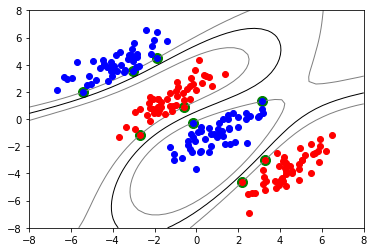

None


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from cvxopt import matrix,solvers

# 生成线性不可分数据点
def gen_data():
    mean1 = [-1, 2]
    mean2 = [1, -1]
    mean3 = [4, -4]
    mean4 = [-4, 4]
    cov = [[1.1, 0.8], [0.8, 1.1]]
    x1 = np.random.multivariate_normal(mean1, cov, 50)
    x1 = np.vstack((x1, np.random.multivariate_normal(mean3, cov, 50)))
    y1 = np.ones(len(x1))
    x2 = np.random.multivariate_normal(mean2, cov, 50)
    x2 = np.vstack((x2, np.random.multivariate_normal(mean4, cov, 50)))
    y2 = np.ones(len(x2)) * -1
    return x1, y1, x2, y2

# 画出边界
def plot_contour(x, y, clf):
    plt.plot(x[:, 0], x[:, 1], "ro")
    plt.plot(y[:, 0],y[:, 1], "bo")
    plt.scatter(clf.sv[:, 0], clf.sv[:, 1], s=100, c='g')
    x1, x2 = np.meshgrid(np.linspace(-8, 8, 50), np.linspace(-8, 8, 50))
    x = np.array([[x1, x2] for x1, x2, in zip(np.ravel(x1), np.ravel(x2))])
    z = clf.project(x).reshape(x1.shape)
    plt.contour(x1, x2, z, [0.0], colors='k', linewidths=1, origin='lower')
    plt.contour(x1, x2, z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
    plt.contour(x1, x2, z - 1, [0.0], colors='grey', linewidths=1, origin='lower')
    plt.show()

# 线性核函数
def linear_kernel(x, y):
    return np.dot(x, y)

# 高斯核函数
def gaussian_kernel(x1, x2, sig=5):
    return np.exp(-np.linalg.norm(x1 - x2) ** 2 / (2 * (sig ** 2)))

# 多项式核函数
def polynomial_kernel(x, y, p=6):
    return (1 + np.dot(x, y)) ** p

class SVM(object):
    def __init__(self, kernel, c=None):
        self.kernel = kernel
        self.c = c  # soft margin
        self.a = 0  # 拉格朗日乘数
        self.sv = 0  # 支撑向量
        self.sv_y = 0  # 支持向量的标签
        self.b = 0  # 截距
        if c is not None:
            self.c = float(self.c)

    def fit(self, x, y):
        n_samples, n_features = x.shape
        # 计算高斯核矩阵(xi*xj)
        K = np.zeros([n_samples, n_samples])
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = self.kernel(x[i], x[j])
        # 计算出svm对偶问题中，二次规划所需要的系数
        P = matrix(np.outer(y, y) * K)
        q = matrix(np.ones(n_samples) * -1)
        A = matrix(y, (1, n_samples))
        b = matrix(0.0)
        if self.c is None:
            G = matrix(np.diag(np.ones(n_samples) * -1))
            h = matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.c
            h = matrix(np.hstack((tmp1, tmp2)))
        # 将数据扔进解二次规划的程序中
        solution = solvers.qp(P, q, G, h, A, b)
        a = np.ravel(solution['x'])
        sv = a > 1e-7  # 找出拉格朗日乘数中不为零的地方
        index = np.arange(n_samples)[sv]
        self.a = a[sv]
        self.sv = x[sv]
        self.sv_y = y[sv]
        print("%s support vector out of %s points" % (len(self.a), len(x)))

        # 计算截距b
        for i in range(len(self.a)):
            self.b += self.sv_y[i]
            self.b -= np.sum(self.a * self.sv_y * K[index[i], sv])
        self.b /= len(self.a)

    # 投影到高维空间计算出分类值
    def project(self, x):
        y_predict = np.zeros(len(x))
        for i in range(len(x)):
            s = 0
            for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                s += a * sv_y * self.kernel(x[i], sv)
            y_predict[i] = s
        return y_predict + self.b


if __name__ == "__main__":
    x1, y1, x2, y2 = gen_data()
    x = np.vstack((x1, x2))
    y = np.append(y1, y2)
    svm = SVM(kernel=gaussian_kernel)
    svm.fit(x, y)
    print(plot_contour(x1, x2, svm))